**Names: Philipp Köhler, Alexander Bespalov**


# Sheet 9

## 1 Pretraining LLMs

### (a)
1. Sentence Ordering Prediciton (SOP)\
Given two sentences the model has to predict wether one sentence follws the other or the other way around. This enables the model to understand temporal and logical progession. It is important for summarization, understandig and coherence. Compared to NSP the understanding is more fine-grained and improves understanding of contextual dependencies.
2. Coreference Resolution (CR)\
The model must identify which pronouns or noun phrases refer to the same entity. The model learns to track entities which leads to better understanding and coherence over longer spans. 

### (b)
1. Sentence Reconstruction (SR)\
A shuffled sentence has to be reordered. This improves the syntactic and grammatical understanding leading to more coherence and flucency. The complexity is $O(n^2)$ (evaluation of all pairwise relations). During training multiple permutations can be processed in parallel.
2. Gap Sentence Generation (GSG)\
Gven a passage with a missing sentence inbeween the missing sentence has to be reconstructed. The model learns to infer missing information leading to better story generation and context based reasoining. Further, bidirecitonal reasoning is promoted. The complexity is $O(n)$ with $n$ being the sentence lenght.  During training multiple gaps can be processed in parallel as it is the case in CLM.

## 2 Under the hood of LLMs: Llama 2.7B

Import modules. Use CUDA(GPU) if abailable. Read access token. Initialize tokenizer and model.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open("access_token.txt", "r") as f:
    access_token = f.read().strip()

model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model, token=access_token, torch_dtype = torch.float16).to(device)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (no

Print token meaning, i.e. the decoded token, for the tokens 5100 to 5109. The number of tokens available tokens is printed. "Sun" is encoded into its token id. The sun_id is decoded again. \<s\> with the id=1 is a token that indicates the start of a sequence. The embedding shape shows that sun_id has two tokens in a 4096 dimensional embedding.

In [2]:
for id in range(5100, 5110):
    print(f"{id=}, {tokenizer.decode([id])}")

print("\ntokenizer length:", len(tokenizer))

sun_id = tokenizer.encode("sun", return_tensors="pt")[-1]
print(f"\n{sun_id=}")

print(tokenizer.decode(sun_id))

emb = model.get_input_embeddings()(sun_id.to(device))
print("embedding shape:", emb.shape)

id=5100, compet
id=5101, pair
id=5102, inglés
id=5103, Response
id=5104, Fig
id=5105, grad
id=5106, documentation
id=5107, cant
id=5108, appreci
id=5109, ån

tokenizer length: 32000

sun_id=tensor([   1, 6575])
<s> sun
embedding shape: torch.Size([2, 4096])


initialize sequence. Encode it and decode it for viewing purpose. Deactivate gradient and compute output of model. Extract logits of the first (and only one) sequence for the last token in the sequence. The shape corresponds to the tokenizer lenght as for each available token a logit is generated. The higher the logit the more probable the token fits as a continuation of the sequence. Convert the logits to probabilites with softmax. Retrieve top 7 most probable tokens. Print the 7 decoded tokens and their probability.

In [3]:
sequence = "My favorite composer is"
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)
print(tokenizer.decode(model_inputs["input_ids"].tolist()[0])) # view tokenized input
with torch.no_grad():
    outputs = model(**model_inputs)

logits = outputs['logits'][0, -1, :]
print("\nlogits shape:", logits.shape)

probabilities = torch.nn.functional.softmax(logits, dim=-1)
top_k = 7
top_prob, top_ind = torch.topk(probabilities, top_k)

print("\nOutputs:\n")

for i in range(top_k):
    print(f"{tokenizer.decode(top_ind[i].tolist())}: {top_prob[i]:.2f}")

<s> My favorite composer is

logits shape: torch.Size([32000])

Outputs:

Moz: 0.25
Ch: 0.11
Be: 0.09
Ludwig: 0.08
Fr: 0.03
Wolfgang: 0.02
Ig: 0.02


Initialize empty sequence. Encode it. Print the generated sequence after adding new tokens. The adding of new tokens follows the steps of calculating the output of the model given the generated answer. Extracting the logits, converting them to probabilties with softmax and choosing the token with the highest probability as the next token. Furtehr, adding the token to the model inputs. The next token is decoded, cleaned from unwanted sign with regex and the generated sequence is printed. This is repeated 30 times.  

In [4]:
import regex as re

sequence = ""
model_inputs = tokenizer(sequence, return_tensors="pt").to(device)

generated_answer = ""
for _ in range(30):
    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs['logits'][0, -1, :]
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        next_token_id = torch.argmax(probabilities).unsqueeze(0)
        model_inputs["input_ids"] = torch.cat([model_inputs["input_ids"], next_token_id.unsqueeze(0)], dim=-1)
    
    next_word = tokenizer.decode(next_token_id.tolist())
    next_word = re.sub(r"[^a-zA-Z0-9.?!]", "", next_word)
    generated_answer += next_word
    generated_answer += " "
    
    print(generated_answer)

Unterscheidung 
Unterscheidung zwischen 
Unterscheidung zwischen  
Unterscheidung zwischen  K 
Unterscheidung zwischen  K raft 
Unterscheidung zwischen  K raft  
Unterscheidung zwischen  K raft  und 
Unterscheidung zwischen  K raft  und  
Unterscheidung zwischen  K raft  und  K 
Unterscheidung zwischen  K raft  und  K raft 
Unterscheidung zwischen  K raft  und  K raft werk 
Unterscheidung zwischen  K raft  und  K raft werk  
Unterscheidung zwischen  K raft  und  K raft werk   
Unterscheidung zwischen  K raft  und  K raft werk    
Unterscheidung zwischen  K raft  und  K raft werk     
Unterscheidung zwischen  K raft  und  K raft werk     K 
Unterscheidung zwischen  K raft  und  K raft werk     K raft 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und 
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  
Unterscheidung zwischen  K raft  und  K raft werk     K raft  und  K 
Unterscheidung zwische

## 3 Flow-based modeling

### (a)
$$
Y' = CDF_Y^{-1}(X) \Leftrightarrow CDF_Y(Y')=X
$$
And
$$
CDF_Y(Y)=X
$$
per definition.
$$
\Rightarrow Y = Y'
$$
Both distributions are equal, therefore their CDF and PDF are qual.

### (b)

For each random distribution X and Y it holds:
$$
CDF_X(X)=U, CDF_Y(Y)=U
$$
where U is a uniform distribution between 0 and 1. A transformation of one distribution to another can be therefore obtained by the following formula.
$$
CDF_X(X)=CDF_Y(Y) \\
\Leftrightarrow Y = CDF_Y^{-1}(CDF_X(X))
$$
The CDF of a distribution can be calculated from:
$$
CDF_Y(x) = \int_{-\inf}^x p_Y(x) dx
$$

For $p_X(x) = \frac{1}{2}x, x \in [0,2]$:
$$
CDF_X(x) = \int_{0}^x  \frac{1}{2}x dx = \frac{1}{4}x^2
$$
For $p_Y(y) = -\frac{1}{2}y+1, y \in [0,2]$:
$$
CDF_Y(y) = \int_{0}^y  -\frac{1}{2}y+1 dy = -\frac{1}{4}y^2+y\\
\Leftrightarrow 0 = y^2-4y+4CDF_Y(y)\\
\Leftrightarrow y=2 \pm \sqrt{4-4CDF_Y(y)}\\
\Leftrightarrow y=2 \pm 2\sqrt{1-CDF_Y(y)}
$$
condsidering $y \in [0,2]$ the solution limits to:
$$
CDF_Y(u)^{-1}=2 - 2\sqrt{1-u}
$$
with $ u \in U $

The resulting transformation is:
$$
y = 2 - 2\sqrt{1-\frac{1}{4}x^2}
$$

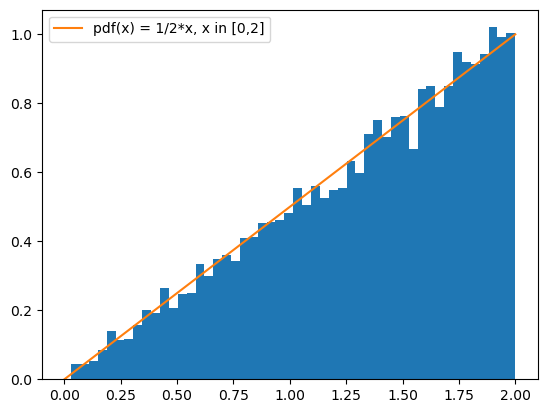

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load the 1d samples:
samples = np.load("data/samples_1d.npy")

x_lin = np.linspace(0, 2, 1000)
plt.hist(samples, bins=50, density=True)
plt.plot(x_lin, 1/2 * x_lin, label="pdf(x) = 1/2*x, x in [0,2]")
plt.legend()
plt.show()

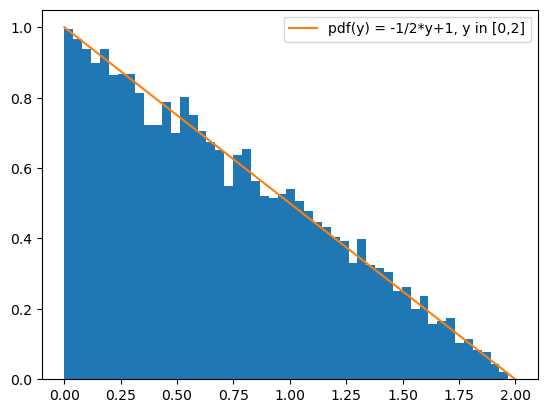

In [2]:
# TODO: transform the samples to samples from pdf(y) = -1/2*y + 1, y in [0,2]
def transform(x):
    return 2-2*np.sqrt(1-1/4 * x**2)

y = transform(samples)

y_lin = np.linspace(0, 2, 1000)
plt.hist(y, bins=50, density=True)
plt.plot(y_lin, -1/2 * y_lin + 1, label="pdf(y) = -1/2*y+1, y in [0,2]")
plt.legend()
plt.show()

### (c)

Using the marginal radial distribution $p_r(r)=re^{-r^2/2}, r\geq0$ for the radial component. The CDF_r becomes:
$$
CDF_r(x)=\int_0^x xe^{-x^2/2}dx=1-e^{-x^2/2}\\
\Leftrightarrow x = \sqrt{-2ln(1-CDF_r(x))}
$$
Using that $CDF_r(r)= U$. With U being a uniform distributon $U \in [0,1]$. It holds $1-U =U$, simplifying the expression:
$$
CDF_r^{-1} = \sqrt{-2ln(CDF_r(x))}
$$
As $CDF_U(x)=x$ the transform of the uniform variable to the radial variable becomes:
$$
r = \sqrt{-2ln(U)}
$$
Looking at $\phi$ the distribution is $p_{\phi}(\phi)=\frac{1}{2\pi}$ with $\phi \in [0,2\pi]$. 
$$
CDF_{\phi}(x)=\int_0^{x}\frac{1}{2\pi}dx = \frac{x}{2\pi}\\
\Leftrightarrow x = 2\pi CDF_{\phi}(x)
$$
Resulting in the transformation:
$$
\phi = 2\pi U
$$
Using that $(x1, x2) = r(cos \phi,sin \phi)$ gives a 2D standard normal distribution, the Box-Müller tranform becomes:
$$
\sqrt{-2ln(U_1)}(cos 2\pi U_2,sin 2\pi U_2)
$$
$U_1,U_2 \in [0,1]$ are uniform distributions.



### (d)
In general mulitvariate distributions can have non separable marginals, not analytically tractable marignal distributions, not closed form CDFs or non invertible CDFs. In all those cases the method is not applicable.

### (e)
$$
CDF_X(x)=CDF_Y(y) = CDF_Y(h(x))
$$
I h(x) is increasing, else:
$$
CDF_X(x)=1-CDF_Y(h(x))
$$
The difference in further calculations is up to sign and is considered in the later calculation by taking the absoulte value of the derivative of h.
$$
\Rightarrow\frac{d}{dx}CDF_X(x) =\frac{d}{dx}CDF_Y(h(x))\\
\Leftrightarrow p_X(x) = \frac{d}{dy}CDF_Y(y)\left|\frac{d}{dx}h(x)\right|
$$
Use $y=h(x)$ and add dashes to the $\frac{d}{dx}h(x)$ due to the fact that the probabilites are larger or eqal than zero per definition.
$$
\Leftrightarrow p_X(x) = p_Y(y)\frac{dh}{dx}(x)\Big|_{y=h(x)} \\
\Leftrightarrow \left( p_X(x)\left| {\frac{dh}{dx}(x)} \right| ^{-1}\right)\Bigg|_{x=h^{-1}(y)} =p_Y(y)
$$